# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
print("All packages installed")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.
All packages installed


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print("Brain name stored")

Brain name stored


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
#Define the Function Approximator Model (Q Network)
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self,stateSize,actionSize,seed,fc1Units=64,fc2Units=64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(stateSize,fc1Units)
        self.fc2 = nn.Linear(fc1Units,fc2Units)
        self.fc3 = nn.Linear(fc2Units,actionSize)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

print("The QNetwork has been defined")

The QNetwork has been defined


In [7]:
#Define the DQN agent for this project 
import numpy as np
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt
import torch.optim as optim

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LEARNING_RATE = 5e-4
UPDATE_EVERY = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NavAgent():
    def __init__(self,stateSize,actionSize,seed):
        self.state_size = stateSize
        self.action_size = actionSize
        self.seed = random.seed(seed)
        
        #Q Network from earlier defined QNetwork model
        self.qnetwork_local = QNetwork(state_size,action_size,seed).to(device)
        self.qnetwork_target = QNetwork(state_size,action_size,seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr= LEARNING_RATE)
        
        #Replay buffer Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        #Set start timestep to 0
        self.t_step=0
        
    def step(self,state,action,reward,nextState,done):
        self.memory.add(state,action,reward,nextState,done)
        #Learn every 4 steps
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experiences=self.memory.sample()
                self.learn(experiences,GAMMA)
        
    def act(self,state,eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self,experiences,gamma):
        states,actions,rewards,next_states,dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma* Q_targets_next * (1-dones))
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        #Loss
        loss = F. mse_loss(Q_expected, Q_targets)
        #Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
        
    def soft_update(self,local_model,target_model, tau):
        for target_param,local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

class ReplayBuffer:
    def __init__(self,actionSize,buffer_size,batch_size,seed):
        self.action_size= actionSize
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])
        self.seed = random.seed(seed)
        
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)
    
print("The DQN Agent and Memory Buffer has been defined")

The DQN Agent and Memory Buffer has been defined


In [11]:
#Create the agent
nav = NavAgent(stateSize=37,actionSize=4,seed =0)
print("Agent created")


Agent created


Episode 100	Average Score: 2.49
Episode 200	Average Score: 7.49
Episode 300	Average Score: 9.32
Episode 400	Average Score: 12.68
Episode 412	Average Score: 23.0
Environment solved in 312 episodes!	Average Score: 13.04


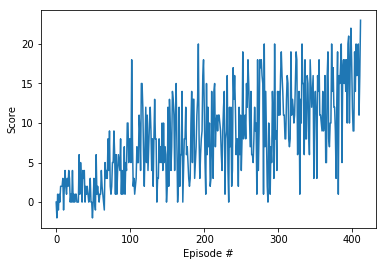

In [12]:
#Train the Agent 
from matplotlib import pyplot as plt

def dqn(n_episodes=4000, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.8):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1,n_episodes+1):
        #Environment Reset statement
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]   
        score = 0
        for t in range(max_t):
            #Updated Action Statements for Unity Environment
            action = nav.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            nav.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break
                
        #print("\nEpisode {}\tScore: {}".format(i_episode,score), end = "") 
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end,eps_decay*eps)
        
        print('\rEpisode {}\tAverage Score: {}'.format(i_episode,score), end = "")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {}'.format(i_episode,np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {}'.format(i_episode-100,np.mean(scores_window)))
            torch.save(nav.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
